In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import urllib
import requests
import time
import japanize_matplotlib
from sklearn.metrics import mean_squared_error
from scipy import stats as st

In [2]:
holidays=pd.read_csv("holidays_in_japan.csv")
match=pd.read_csv("match_reports.csv")
sub_df=pd.read_csv("sample_submit.csv",header=None)
test=pd.read_csv("test.csv")
train=pd.read_csv("train.csv")
venue=pd.read_csv("venue_information.csv")

# データフレームを合成

In [3]:
train.columns

Index(['id', 'match_date', 'kick_off_time', 'section', 'round', 'home_team',
       'away_team', 'venue', 'weather', 'temperature', 'humidity',
       'broadcasters', 'attendance'],
      dtype='object')

In [4]:
train["attendance"].describe()

count     3366.000000
mean     17961.112299
std       9468.784878
min          0.000000
25%      11490.500000
50%      15322.000000
75%      21084.750000
max      62632.000000
Name: attendance, dtype: float64

In [5]:
df=pd.concat([train,test],axis=0)

In [6]:
df[df["attendance"]<5000]

,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,attendance
48,9238,2006-04-02,14:04,第6節,第2日,京都,福岡,京都市西京極総合運動公園陸上競技場兼球技場,雨,16.0,85.0,BS-i/KBS京都(録)/J SPORTS(録),3670.0
182,9372,2006-08-30,19:04,第21節,第1日,大宮,福岡,さいたま市浦和駒場スタジアム,曇,25.9,68.0,テレ玉/J SPORTS(録),4873.0
387,10066,2007-05-06,13:03,第10節,第1日,横浜FC,神戸,横浜市三ツ沢公園球技場,雨,17.2,83.0,スカパー!(パーフェクト チョイス)/e2(スカチャン!),4458.0
414,10093,2007-05-26,13:03,第13節,第1日,横浜FC,大分,横浜市三ツ沢公園球技場,晴,27.5,38.0,スカパー!(パーフェクト チョイス)/e2(スカチャン!),4935.0
569,10248,2007-10-27,14:03,第30節,第1日,横浜FC,大宮,横浜市三ツ沢公園球技場,雨,17.0,87.0,スカパー!・e2(J sports Plus)/BS,4114.0
1564,13272,2011-07-13,19:00,第4節,第2日,福岡,大宮,レベルファイブスタジアム,曇,27.1,84.0,スカパー/スカパー光/e2(フジテレビTWO),4028.0
2479,15699,2014-03-23,15:04,第4節,第1日,浦和,清水,埼玉スタジアム2002,晴,16.2,23.0,スカパー!/スカパー!プレミアムサービス/テレ玉,0.0
2608,15829,2014-08-02,18:34,第18節,第1日,徳島,甲府,鳴門・大塚スポーツパークポカリスエットスタジアム,雨,24.4,91.0,スカパー!/スカパー!プレミアムサービス,3594.0
2749,15970,2014-12-08,19:03,第34節,第2日,新潟,柏,県立カシマサッカースタジアム,晴,7.0,63.0,スカパー!/スカパー!プレミアムサービス,2104.0


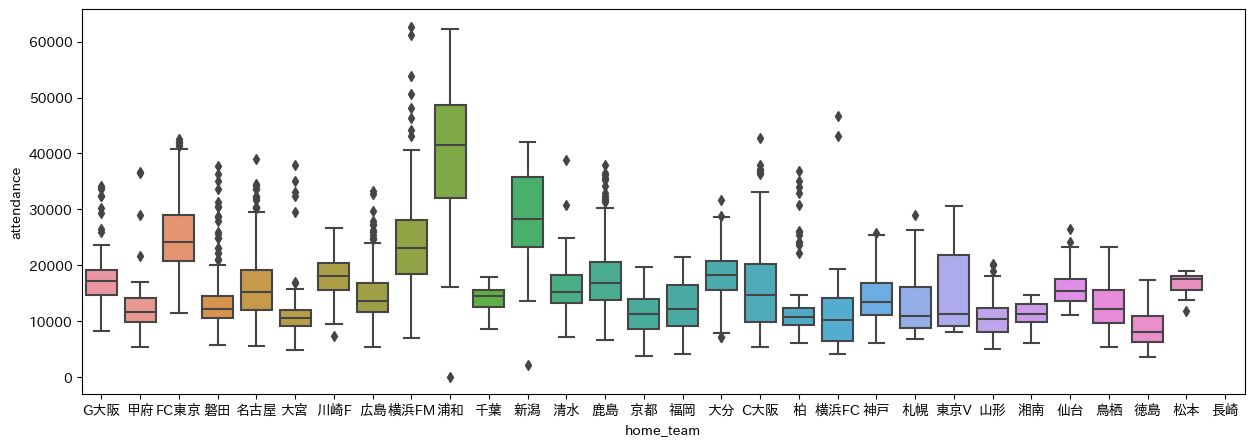

In [7]:
plt.figure(figsize=(15,5))
sns.boxplot(x="home_team",y="attendance",data=df)
plt.show()

In [8]:
df["capacity"]=np.nan

In [9]:
df=df.merge(venue[["venue","capacity","address"]],on="venue",how="left").drop("capacity_x",axis=1)

# 当日、次の日がholidayかどうか

In [10]:
df['is_next_day_holiday'] = df['match_date'].apply(lambda x: 1 if (x + pd.Timedelta(days=1)) in holidays['holiday_date'].values else 0)
df['is_this_day_holiday'] = df['match_date'].apply(lambda x: 1 if (x + pd.Timedelta(days=0)) in holidays['holiday_date'].values else 0)
df=df.drop("match_date",axis=1)

TypeError: can only concatenate str (not "Timedelta") to str

In [ ]:
df["section"]=df["section"].apply(lambda x:int(x[1]))
df["round"]=df["round"].apply(lambda x:int(x[1]))

# kick_off_timeが夜かどうか

In [ ]:
df["kick_off_hour"]=df["kick_off_time"].apply(lambda x: int(x[:2]))

In [ ]:
plt.hist(df["kick_off_hour"])

# 昼と夜に2分割する

In [ ]:
df["kick_off_time_is_night"]=df["kick_off_hour"].apply(lambda x: 1 if x>=16 else 0)

In [ ]:
df=df.drop(["kick_off_time","kick_off_hour"],axis=1)

In [ ]:
df

# 座標取得

In [ ]:
for i,j in df["address"].value_counts().items():
    makeUrl = "https://msearch.gsi.go.jp/address-search/AddressSearch?q="
    s_quote = urllib.parse.quote(i)
    response = requests.get(makeUrl + s_quote)
    ido=response.json()[0]["geometry"]["coordinates"][::-1]
    print(i,ido)
    df.loc[df["address"]==i,["x","y"]]=ido
    time.sleep(0.5)

In [ ]:
df=df.drop(["venue","address"],axis=1)

# データフレームをリセット　ココで一時保存

In [ ]:
# df.to_csv('latlng(1).csv', index=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import urllib
import requests
import time
import japanize_matplotlib
from sklearn.metrics import mean_squared_error
from scipy import stats as st
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import median_absolute_error
df=pd.read_csv("latlng.csv")
sub_df=pd.read_csv("sample_submit.csv",header=None)
test=pd.read_csv("test.csv")
train=pd.read_csv("train.csv")

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(x="away_team",y="attendance",data=df)
plt.show()

In [ ]:
df=df[(df["attendance"]>=0)&(df["attendance"]<=62241.0)|(df["attendance"].isnull())]

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(x="away_team",y="attendance",data=df)
plt.show()

# 天気の処理

In [ ]:
plt.figure(figsize=(15,5))
sns.scatterplot(x="weather",y="attendance",data=df)
plt.xticks(rotation=45)
plt.show()

In [ ]:
df["weather"]=df["weather"].apply(lambda x:x[0] if "一時" or "時々" in x else x)
df["weather"]=df["weather"].apply(lambda x: "雨" if x=="霧" or x=="雷" or x=="雪"  else x)
df["weather"].value_counts()

In [ ]:
plt.figure(figsize=(15,5))
sns.scatterplot(x="weather",y="attendance",data=df)
plt.xticks(rotation=45)
plt.show()

# weatherエンコーディング

In [ ]:
encoded_df = pd.get_dummies(df['weather']).astype(int)

In [ ]:
df=pd.concat([df,encoded_df],axis=1)

In [ ]:
df=df.drop("weather",axis=1)

# チームの処理

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# home_team列をラベルエンコーディング
df['home_team_encoded'] = label_encoder.fit_transform(df['home_team'])

# away_team列をラベルエンコーディング
df['away_team_encoded'] = label_encoder.transform(df['away_team'])


In [ ]:
# df=df.drop(["home_team","away_team","broadcasters"],axis=1)
df

In [ ]:
# 相関行列
correlation_coefficients = df.corr()  # 相関行列の計算
# 相関行列のヒートマップ (相関係数の値あり) 
plt.rcParams['font.size'] = 12
plt.figure(figsize=(12, 8))  # この段階で画像のサイズを指定する
sns.heatmap(correlation_coefficients, vmax=1, vmin=-1, cmap='seismic', square=True,  xticklabels=1, yticklabels=1)
plt.xlim([0, correlation_coefficients.shape[0]])
plt.show()

# 予測モデル構築

In [ ]:
train_df=df[df["attendance"].notnull()]
test_df=df[df["attendance"].isnull()]

In [ ]:
# train_df.to_csv("new_train.csv")
train_df

In [ ]:
train_x=train_df.drop(["attendance","id","雨","曇","屋","humidity"],axis=1)
train_y=train_df["attendance"]
test_x=test_df.drop(["attendance","id","雨","曇","屋","humidity"],axis=1)
test_y=test_df["attendance"]

In [ ]:
train_y

# ランダムフォレスト回帰

In [ ]:
# モデルの構築
model = RandomForestRegressor()

# クロスバリデーションによるスコア計算
scores1 = cross_val_score(best_model, train_x, train_y, cv=5, scoring='neg_root_mean_squared_error')


# RMSEの平均値
rmse_mean = -scores1.mean()

print("Mean RMSE:", rmse_mean)


In [ ]:
# ハイパーパラメータの範囲を指定
param_grid = {
    'n_estimators': [80,100,120],
    'max_depth': [9,10,11],
    'min_samples_split': [7,8,9]
}

# モデルの構築
model = RandomForestRegressor()

# グリッドサーチによるモデルのチューニング
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(train_x, train_y)

# 最適なモデルの取得
best_model = grid_search.best_estimator_

# クロスバリデーションによるスコア計算
scores = cross_val_score(best_model, train_x, train_y, cv=5, scoring='neg_root_mean_squared_error')

# RMSEの平均値
rmse_mean = -scores.mean()

print("Mean RMSE:", rmse_mean)
# # テストデータの予測
# y_pred = best_model.predict(X_test)

# # RMSEの計算
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# print("RMSE:", rmse)


In [ ]:
best_model.get_params()

In [ ]:
# 特徴量の重要度を取得
importance = best_model.feature_importances_
# 重要度の降順で特徴量のインデックスをソート
indices = np.argsort(importance)[::-1]

# 特徴量の重要度と名前を表示
for i in range(len(importance)):
    print(f"{i+1}. 特徴量名: {train_x.columns[indices[i]]}, 重要度: {importance[indices[i]]}")
# バー グラフの作成
plt.figure(figsize=(10, 6))
plt.bar(range(len(importance)), importance[indices], align='center')
plt.xticks(range(len(importance)), train_x.columns[indices], rotation='vertical')
plt.xlabel('特徴量')
plt.ylabel('重要度')
plt.title('ランダムフォレスト回帰モデルの特徴量の重要度')
plt.tight_layout()

# グラフの表示
plt.show()

In [ ]:
pre_y=best_model.predict(test_x)

In [ ]:
sub_df[1]=pre_y

# SVCモデル構築

In [ ]:
from sklearn.svm import SVR

In [ ]:
svr=SVR()
# パラメータグリッドの定義
params = {
    "kernel": ["linear", "rbf", "poly"],
    "C": [0.1, 1, 10, 100],
    "epsilon": [0.01, 0.1, 0.5, 1],
    "gamma": ["scale", "auto"]
}

# グリッドサーチで最適なハイパーパラメータを探索
grid = GridSearchCV(svr, params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid.fit(train_x, train_y)


# 最適なハイパーパラメータとスコアを表示
print("Best parameters:", grid.best_params_)
print("Best score:", -grid.best_score_)


# 最適なモデルを取得
best_model = grid.best_estimator_

# テストデータでの予測
y_pred = best_model.predict(train_x)

In [ ]:
# csvファイルに追記するデータフレームを作成
score_df = pd.DataFrame([[grid_.bes_params_,-grid.best_score_]], columns=["best_params_svr", "best_score"])

# csvファイルにデータフレームを追記
score_df.to_csv("score.csv", mode="a", header=False, index=False)

# モデル提出

In [ ]:
# sub_df.to_csv("submit.csv",header=None,index=None)

In [ ]:
test_y=pd.DataFrame(pre_y)

In [ ]:
test=pd.concat([test_x,test_y])

# LightGBM実装

In [12]:
from sklearn.model_selection import train_test_split
cat_cols=train_df.dtypes("object").colmns

NameError: name 'train_df' is not defined

In [141]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [152]:
# import optuna.integration.lightgbm as lgb
import lightgbm as lgb
# LightGBMデータセットの作成
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

# ハイパーパラメータの設定
params = {
    'objective': 'regression',  # 回帰タスク
    'metric': 'rmse',  # 評価指標
    'boosting_type': 'gbdt',  # 勾配ブースティング
    'num_leaves': 31,  # ノードの最大数
    'learning_rate': 0.05,  # 学習率
    'feature_fraction': 0.9,  # 特徴量のサブサンプリング
    'bagging_fraction': 0.8,  # データのサブサンプリング
    'bagging_freq': 5,  # データのサブサンプリングの頻度
    'verbosity': -1,  # 学習中のログの出力レベル
    "categorical_feature":
}

# LightGBMモデルのトレーニング
model = lgb.train(best_params, lgb_train, valid_sets=[lgb_train, lgb_val], callbacks=[lgb.early_stopping(10), lgb.log_evaluation(10)])

#ベストのパラム
# best_params=model.params

# 検証データの予測
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

# RMSEスコアの計算
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print("Validation RMSE:", rmse)



C:\Users\zekus\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 7228.49	valid_1's rmse: 6867.77
[20]	training's rmse: 5988.03	valid_1's rmse: 5819.94
[30]	training's rmse: 5357.61	valid_1's rmse: 5377.15
[40]	training's rmse: 4982.12	valid_1's rmse: 5143.67
[50]	training's rmse: 4739.1	valid_1's rmse: 4987.7
[60]	training's rmse: 4551.96	valid_1's rmse: 4915.51
[70]	training's rmse: 4393.64	valid_1's rmse: 4846.19
[80]	training's rmse: 4268.21	valid_1's rmse: 4820.9
[90]	training's rmse: 4161.32	valid_1's rmse: 4813.8
[100]	training's rmse: 4079.96	valid_1's rmse: 4806.07
[110]	training's rmse: 3994.15	valid_1's rmse: 4803.2
[120]	training's rmse: 3916.06	valid_1's rmse: 4802.92
Early stopping, best iteration is:
[111]	training's rmse: 3985.44	valid_1's rmse: 4800.36
Validation RMSE: 4800.35911101232


In [154]:
# テストデータの予測
y_pred_test = model.predict(test_x, num_iteration=model.best_iteration)

In [155]:
sub_df[1]=y_pred_test

In [156]:
sub_df.to_csv("submit.csv",index=None,header=None)

In [130]:
pre_test_df=test_df.copy()
pre_test_df["attendance"]=y_pred_test

# スコアとパラムの記録

In [153]:
# csvファイルに追記するデータフレームを作成
score_df = pd.DataFrame([[best_params, rmse]], columns=["best_params", "best_score"])

# csvファイルにデータフレームを追記
score_df.to_csv("score.csv", mode="a", header=False, index=False)